**Task 1. Basic image colorization**.
Description: Implement a simple model that colorizes grayscale photos using basic deep learning techniques. Guidelines: Build the model with Python and a deep learning framework such as TensorFlow or Keras. Concentrate on getting the model to generate observable colorization results. GUI is not necessary.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog
import os

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())

else:
  print("Using CPU")

0


In [2]:
# Function to convert RGB images to grayscale
def rgb_to_gray(images):
    return torch.mean(images, dim=1, keepdim=True)

In [3]:
class ToSketch:
    def __call__(self, img):
        img = np.array(img)  
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
        edges = cv2.Canny(gray_img, 100, 200)  # Apply Canny edge detection
        edges = np.expand_dims(edges, axis=2)  
        return torch.from_numpy(edges).float().permute(2, 0, 1) / 255.0  

In [5]:
from torch.utils.data import Dataset

class InfraredDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale for infrared
        if self.transform:
            img = self.transform(img)
        return img

In [6]:
# Transformation for CIFAR-10 (RGB) images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Transformation for sketch images (using Canny edge detection)
sketch_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    ToSketch(),
])

# Transformation for infrared images
infrared_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load CIFAR-10 dataset for Sketch model
sketch_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=sketch_transform)
sketch_train_loader = DataLoader(sketch_train_dataset, batch_size=64, shuffle=True, num_workers=2)

sketch_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=sketch_transform)
sketch_test_loader = DataLoader(sketch_test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [07:37<00:00, 372304.20it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:

train_infrared_dataset = InfraredDataset(image_dir=r'D:\NullclassInternship\data\train', transform=infrared_transform)
train_infrared_loader = DataLoader(train_infrared_dataset, batch_size=64, shuffle=True, num_workers=2)

test_infrared_dataset = InfraredDataset(image_dir=r'D:\NullclassInternship\data\test', transform=infrared_transform)
test_infrared_loader = DataLoader(test_infrared_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 34572171.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

In [12]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


rgb_model = ColorizationNet().to(device)
sketch_model = ColorizationNet().to(device)
infrared_model = ColorizationNet().to(device)

In [ ]:
model = ColorizationNet().to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [13]:
criterion = nn.MSELoss()
optimizer_rgb = optim.Adam(rgb_model.parameters(), lr=0.001)
optimizer_sketch = optim.Adam(sketch_model.parameters(), lr=0.001)
optimizer_infrared = optim.Adam(infrared_model.parameters(), lr=0.001)

In [14]:
model = ColorizationNet().to(device)
sketch_model = ColorizationNet().to(device)
infrared_model = ColorizationNet().to(device)

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")


    for i, (rgb_images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(rgb_images).to(device)
        rgb_images = rgb_images.to(device)

      
        rgb_outputs = rgb_model(grayscale_images)
        loss_rgb = criterion(rgb_outputs, rgb_images)

        
        optimizer_rgb.zero_grad()
        loss_rgb.backward()
        optimizer_rgb.step()

        if i % 100 == 0:
            print(f"[RGB] Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss_rgb.item():.4f}")


for i, (sketch_images, _) in enumerate(sketch_train_loader): 
    sketch_images = sketch_images.to(device)

  
    sketch_outputs = sketch_model(sketch_images)
    loss_sketch = criterion(sketch_outputs, sketch_images)

    
    optimizer_sketch.zero_grad()
    loss_sketch.backward()
    optimizer_sketch.step()

    if i % 100 == 0:
        print(f"[Sketch] Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(sketch_train_loader)}], Loss: {loss_sketch.item():.4f}")


for i, infrared_images in enumerate(train_infrared_loader):
    infrared_images = infrared_images.to(device)

   
    infrared_outputs = infrared_model(infrared_images)
    loss_infrared = criterion(infrared_outputs, infrared_images)

    
    optimizer_infrared.zero_grad()
    loss_infrared.backward()
    optimizer_infrared.step()

    if i % 100 == 0:
        print(f"[Infrared] Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_infrared_loader)}], Loss: {loss_infrared.item():.4f}")

print("Finished Training")

Epoch [1/30], Step [1/782], Loss: 0.0584
Epoch [1/30], Step [101/782], Loss: 0.0080
Epoch [1/30], Step [201/782], Loss: 0.0053
Epoch [1/30], Step [301/782], Loss: 0.0054
Epoch [1/30], Step [401/782], Loss: 0.0046
Epoch [1/30], Step [501/782], Loss: 0.0055
Epoch [1/30], Step [601/782], Loss: 0.0045
Epoch [1/30], Step [701/782], Loss: 0.0055
Epoch [2/30], Step [1/782], Loss: 0.0056
Epoch [2/30], Step [101/782], Loss: 0.0046
Epoch [2/30], Step [201/782], Loss: 0.0061
Epoch [2/30], Step [301/782], Loss: 0.0048
Epoch [2/30], Step [401/782], Loss: 0.0069
Epoch [2/30], Step [501/782], Loss: 0.0048
Epoch [2/30], Step [601/782], Loss: 0.0062
Epoch [2/30], Step [701/782], Loss: 0.0060
Epoch [3/30], Step [1/782], Loss: 0.0063
Epoch [3/30], Step [101/782], Loss: 0.0048
Epoch [3/30], Step [201/782], Loss: 0.0044
Epoch [3/30], Step [301/782], Loss: 0.0045
Epoch [3/30], Step [401/782], Loss: 0.0050
Epoch [3/30], Step [501/782], Loss: 0.0048
Epoch [3/30], Step [601/782], Loss: 0.0050
Epoch [3/30], Ste

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):

    img = img / 2 + 0.5
    npimg = img.numpy()
    if len(img.shape) == 2:
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):


    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):

    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val


    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0


    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]


    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):

    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):


    images = (images + 1) / 2.0


    images_hsv = torch_rgb_to_hsv(images)


    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)


    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)


    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images

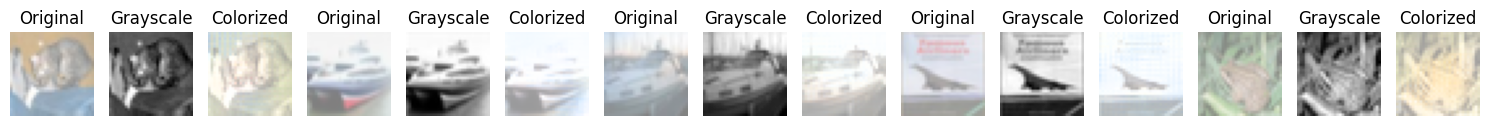

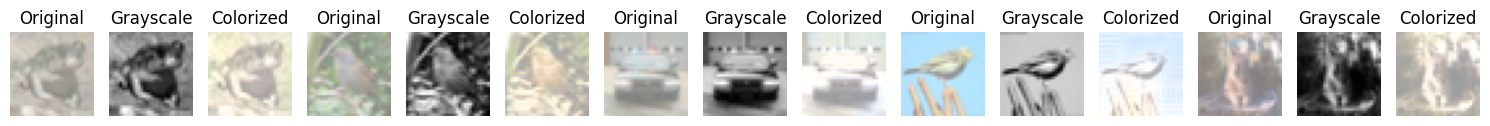

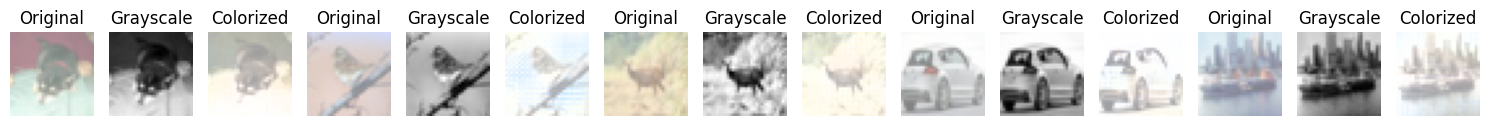

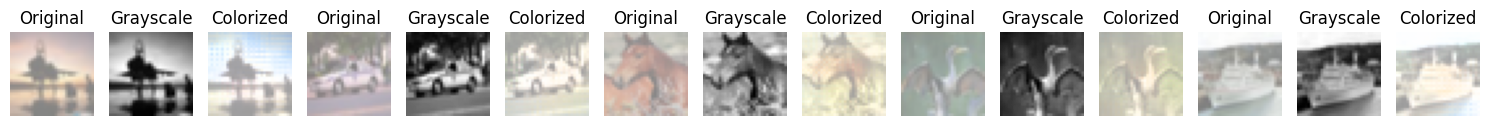

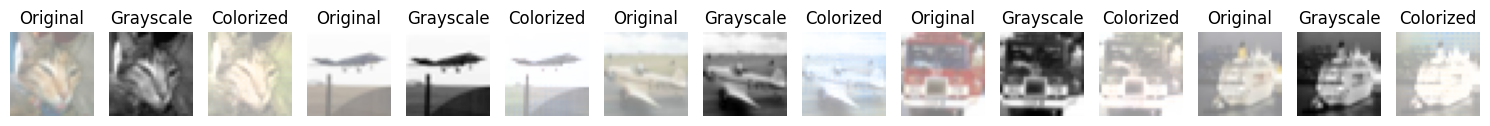

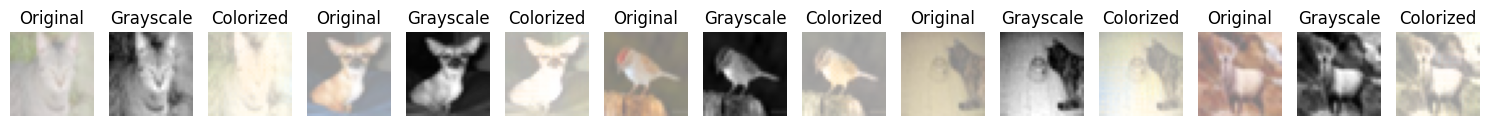

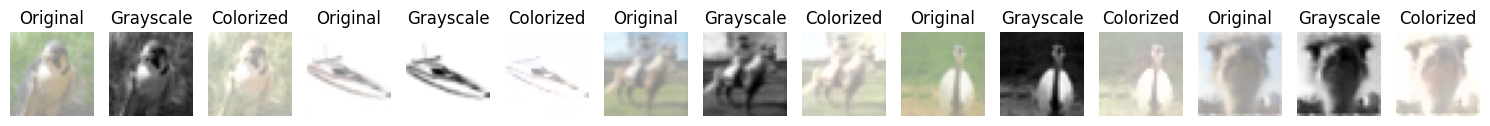

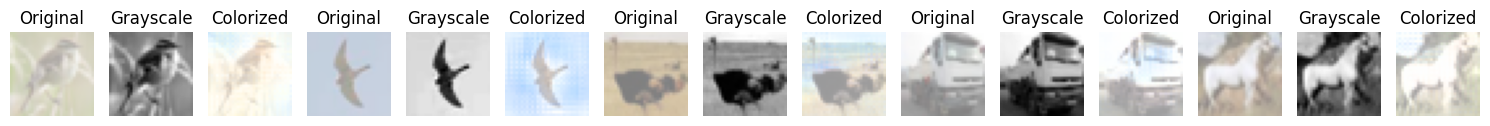

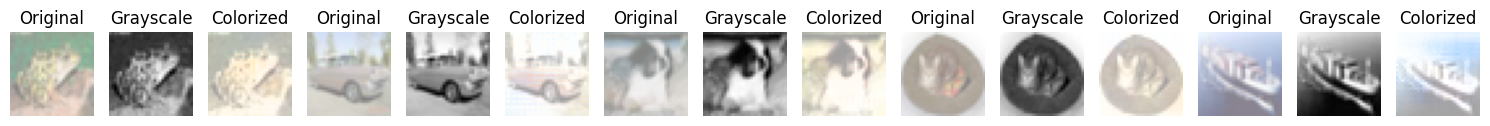

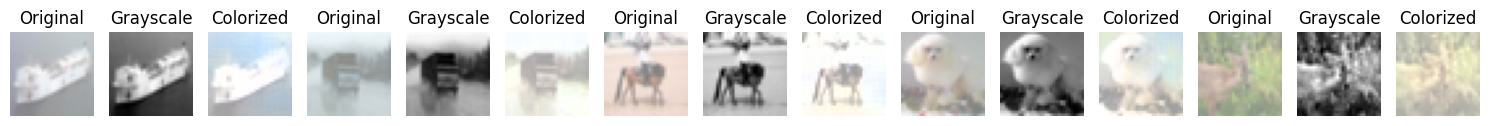

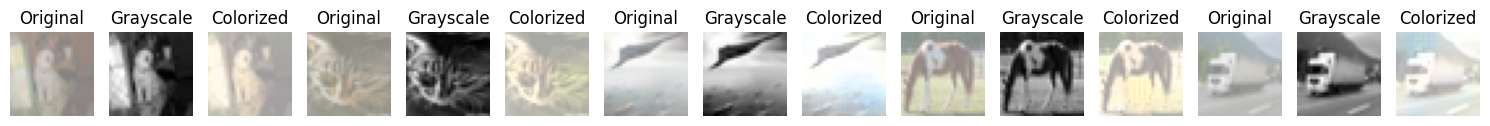

In [ ]:
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)


        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()


        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)


        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:
            break

In [ ]:
import os


current_directory = os.getcwd()


print("Current working directory:", current_directory)

Current working directory: /content


In [ ]:
from PIL import Image


img = Image.open('/content/pexels-photo-372490.jpeg')


gray_img = img.convert("L")

In [ ]:
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),

])

In [ ]:
img_tensor = transform(gray_img).unsqueeze(0)  

model.eval()


img_tensor = img_tensor.to(device)

with torch.no_grad():
    colorized_tensor = model(img_tensor)

In [ ]:
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())


colorized_img.save("_colorized2.jpg")

In [18]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

class ColorizationNet(torch.nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x


root = tk.Tk()
root.title("Cross-Domain Image Colorization")
root.geometry("600x400")


input_panel = tk.Label(root)
input_panel.pack(pady=10)

output_panel = tk.Label(root)
output_panel.pack(pady=10)


model = ColorizationNet()  
model.load_state_dict(torch.load(r'D:\NullclassInternship\colorization_model.pth')) 
model.eval()  


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])


def load_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = Image.open(file_path).convert('L')  
        img = img.resize((256, 256))  
        img_tk = ImageTk.PhotoImage(img)
        input_panel.configure(image=img_tk)
        input_panel.image = img_tk  
        return img


def colorize_image():
    img = load_image()
    if img:
        img_tensor = transform(img).unsqueeze(0)  
        img_tensor = Variable(img_tensor)  

        
        with torch.no_grad():
            output = model(img_tensor)

        
        output_image = output.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
        output_image = (output_image * 255).astype('uint8')

        
        output_pil = Image.fromarray(output_image)
        output_img_tk = ImageTk.PhotoImage(output_pil)
        output_panel.configure(image=output_img_tk)
        output_panel.image = output_img_tk 


load_button = tk.Button(root, text="Load Image", command=colorize_image)
load_button.pack()


root.mainloop()


C:\Users\Rohit\AppData\Local\Temp\ipykernel_4968\773729920.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'D:\NullclassInternship\col

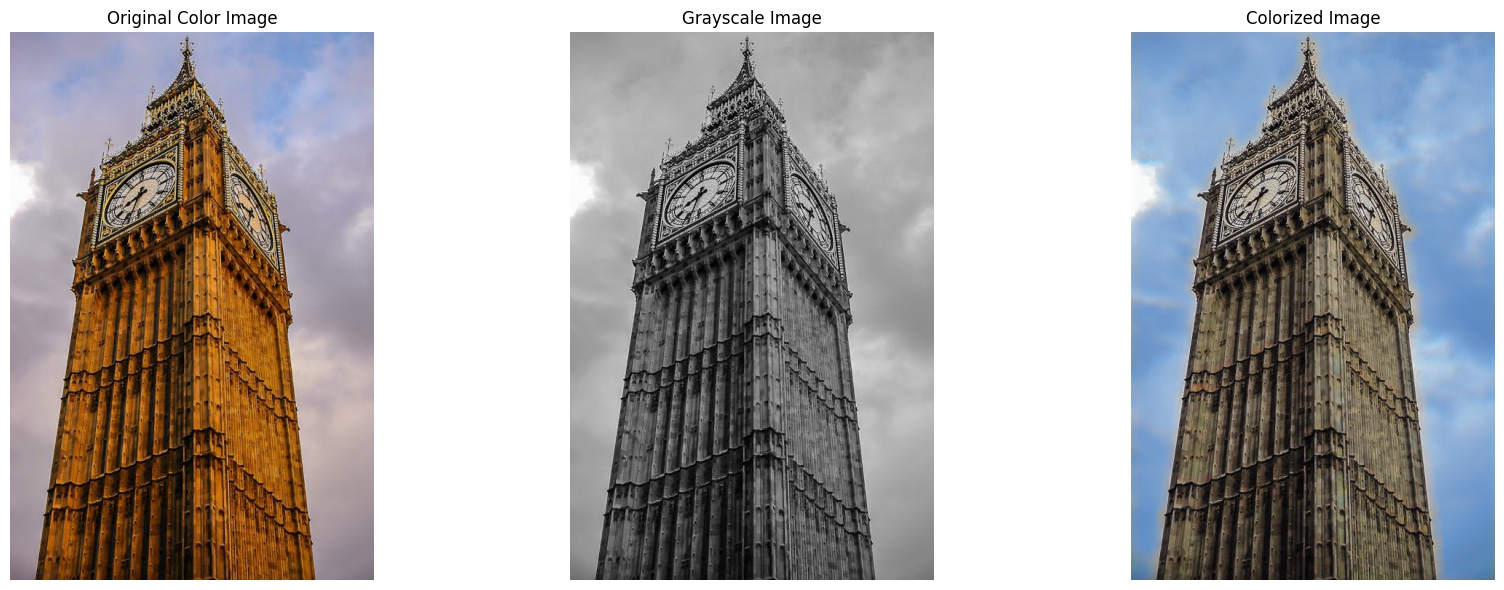

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))


ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')


ax[1].imshow(gray_img, cmap='gray')
ax[1].set_title("Grayscale Image")
ax[1].axis('off')


ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()